Let's go ahead and Get started!

Importing Most of the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV as LogReg
from sklearn import metrics
import matplotlib.pyplot as plt
import gc; gc.enable()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#folder_path ='C:\Users\xxtur\Desktop\J-OMEGALUL-B\IDEE_Fraud_Detection\input'

Combine a couple of dataframes for convenience for noe

In [3]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

def combine_data(transaction, identity):
    data = pd.merge(transaction, 
                    identity, 
                    on='TransactionID', 
                    how='left')
    return data


train = combine_data(train_transaction, train_identity)
test = combine_data(test_transaction, test_identity)

# train = train_transaction.copy()
del train_transaction; del train_identity; gc.collect()

49

In [4]:
import matplotlib.pyplot as plt
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))



<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

# Let's look and see what percent of transactions are what. 

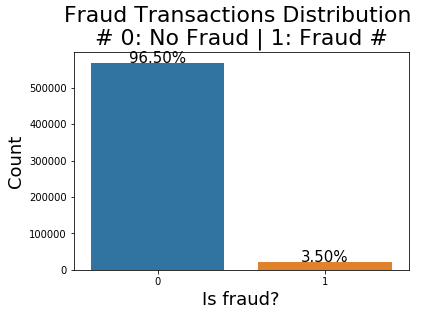

In [5]:
import seaborn as sns
g = sns.countplot(x='isFraud', data=train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 


Yikes, there's pretty significant class imbalance in this problem. We're going to have to figure out a way to accomodate for this or it may influence the model's effectiveness. 

We can...

-- Upsample the Fraudulent Cases

-- Downsample the non-fraud cases

-- Apply a model that accomodates for imbalanced classes

<Figure size 1152x864 with 0 Axes>

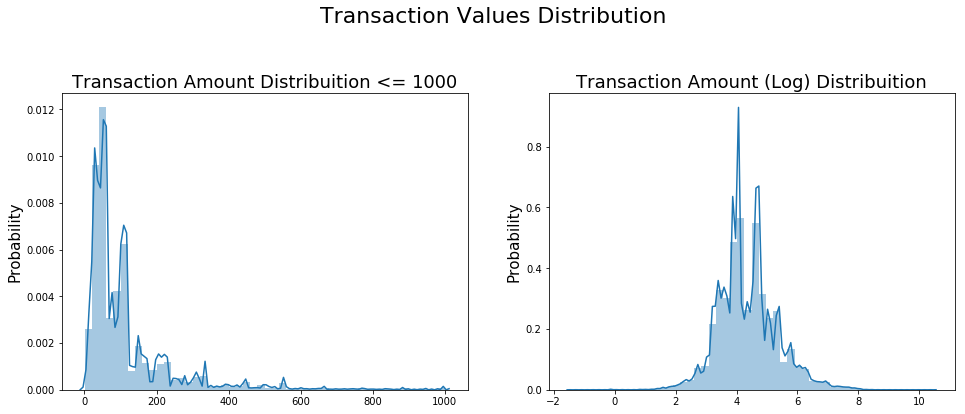

<Figure size 1152x864 with 0 Axes>

In [6]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(train[train['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(train['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))

Here we see that the transaction value doesn't follow a remotely normal distribution, it may be in our best interest to log transform it 

Text(0.5, 0, 'ProductCD Name')

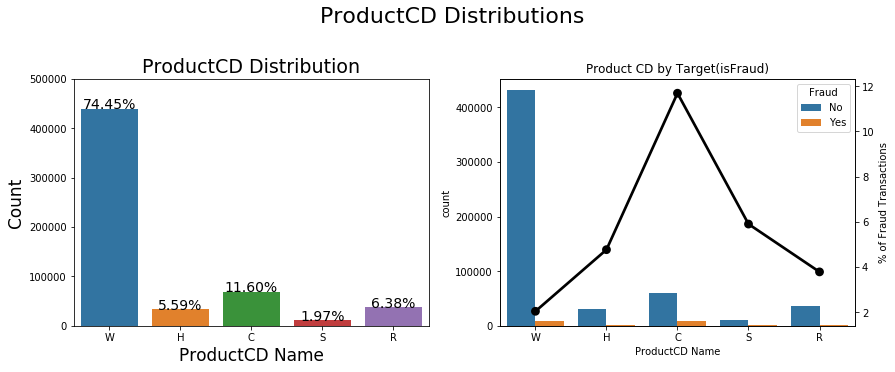

In [7]:
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions")
g1.set_title("Product CD by Target(isFraud)")
g1.set_xlabel("ProductCD Name")


Here we're seeing the incidences of ProductCD and on the right it has the fraudulent and non fraudulent cases alongside that. The black line represents the percentage of Fraudulent transactions. As we can see, ProductCD Name 'C' has a high incidence of fraud. Let's now take some time to examine the effects of the card the user is using. 

In [8]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200].index), 'card3'] = "Others"
train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300].index), 'card5'] = "Others"

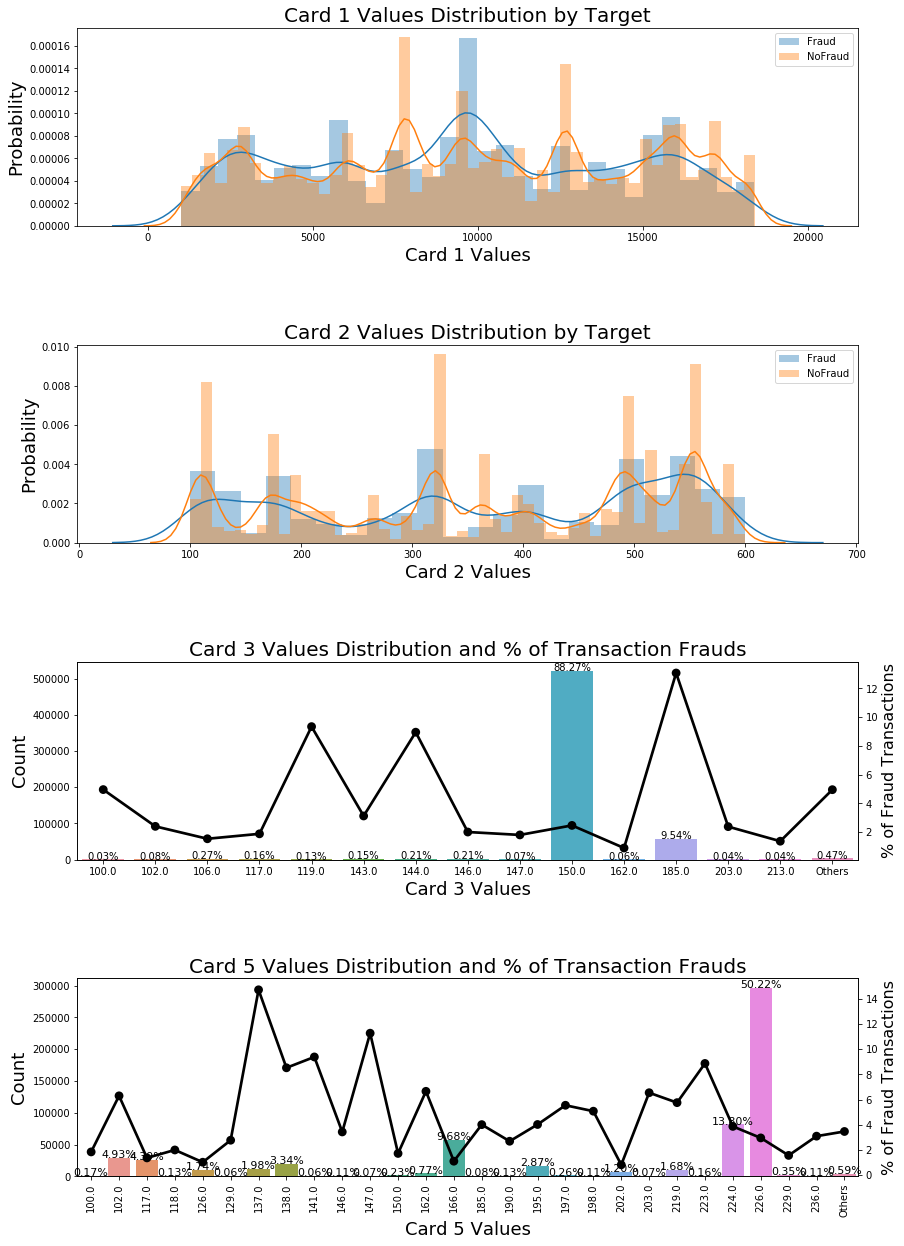

In [9]:
tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=train, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

It certainly appears that certain cards are more likely to be fraudulent when used in transactions. I think these could be useful features.

Text(0, 0.5, 'Count')

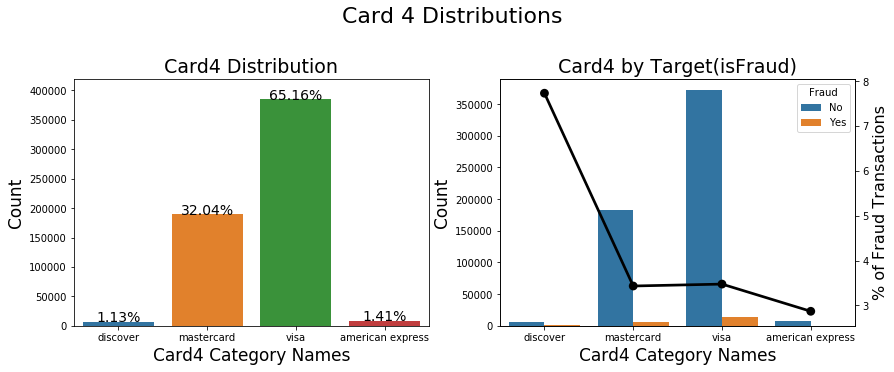

In [10]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

Here We can see that Discovercard is the card chosen for a lot of fraudulent activity, might be a good feature to keep. 

Text(0, 0.5, 'Count')

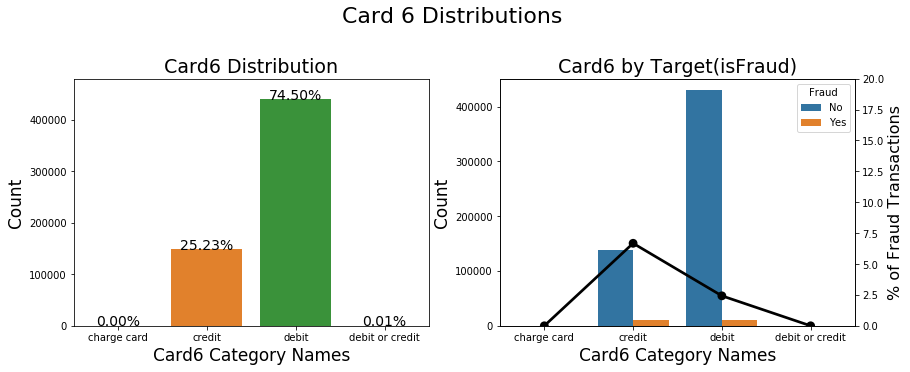

In [11]:
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=train, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)


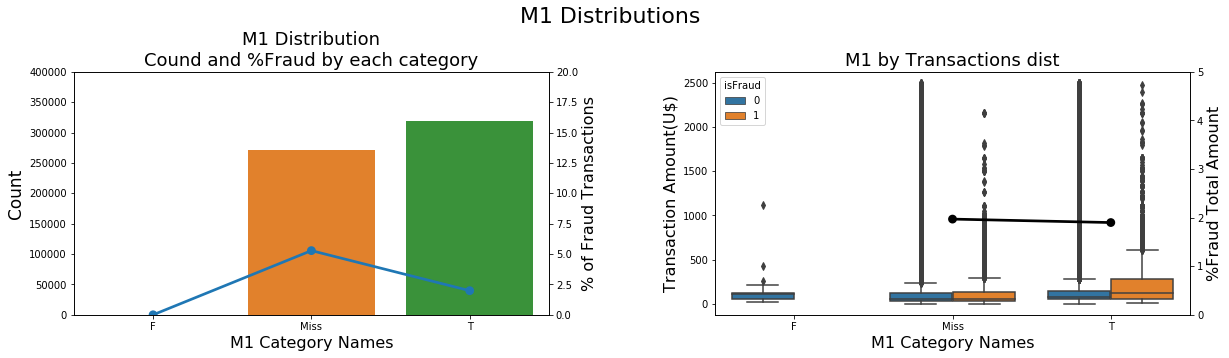

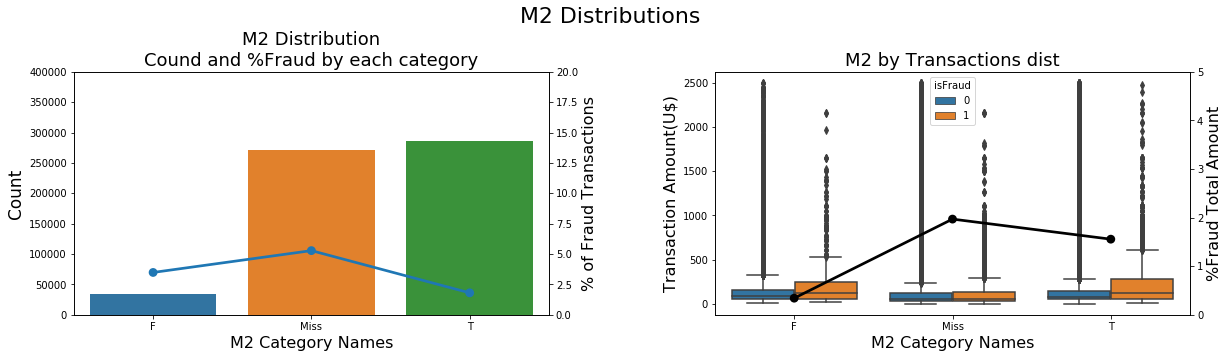

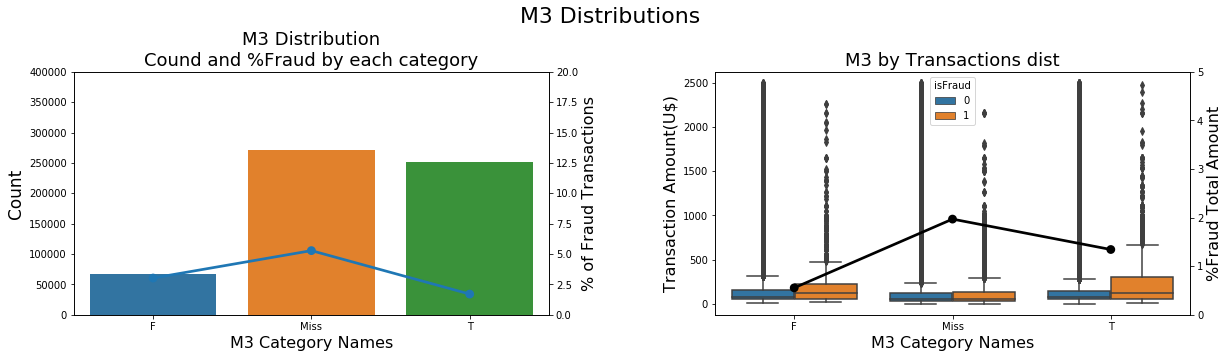

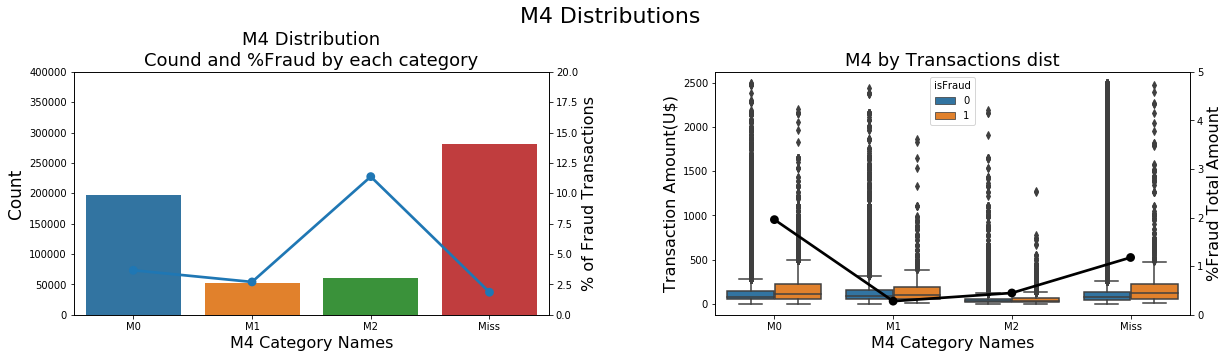

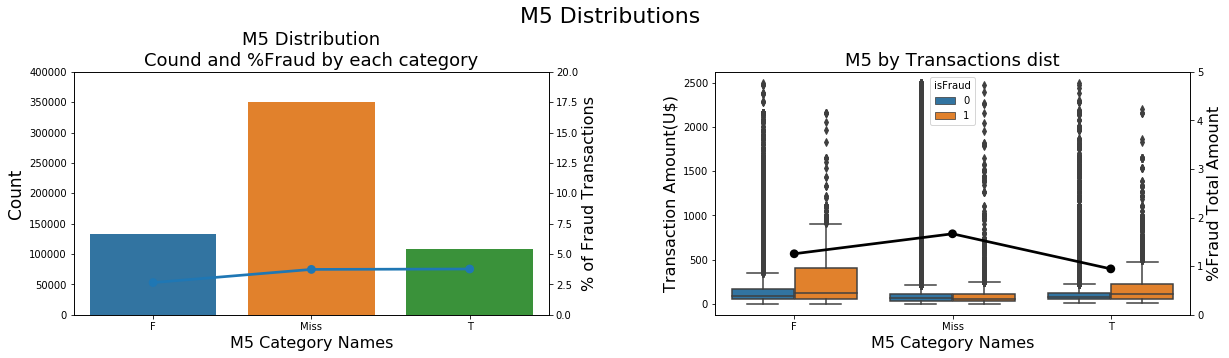

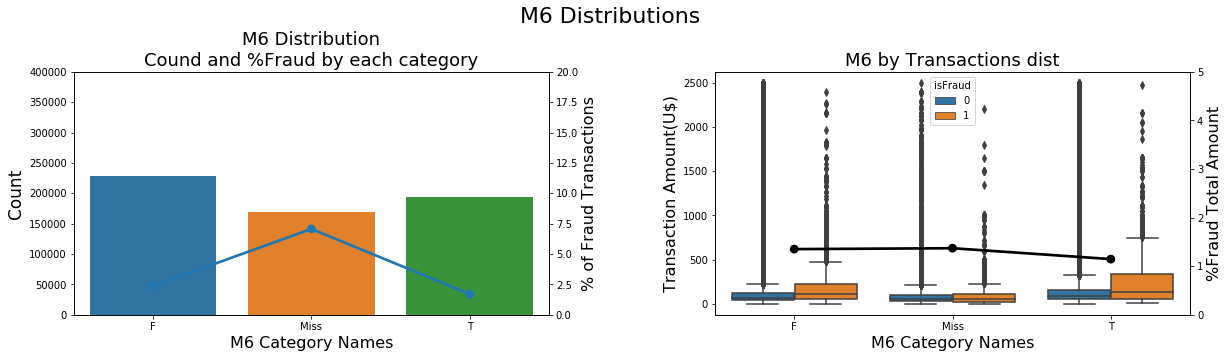

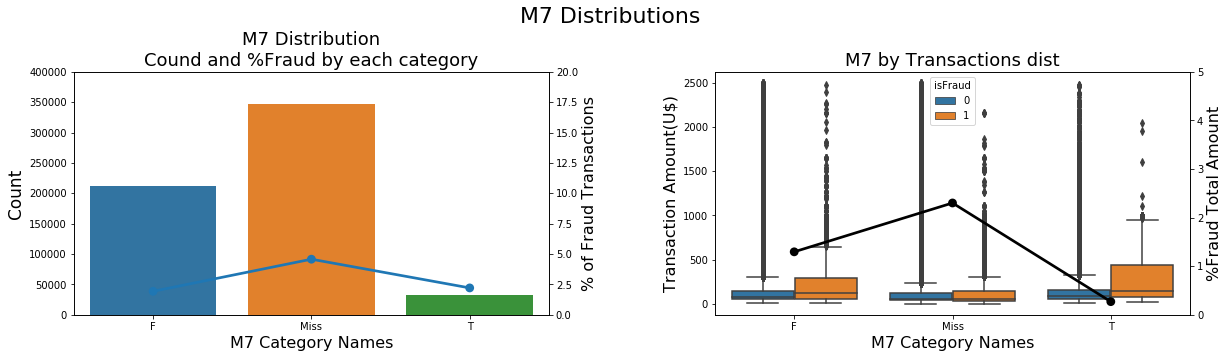

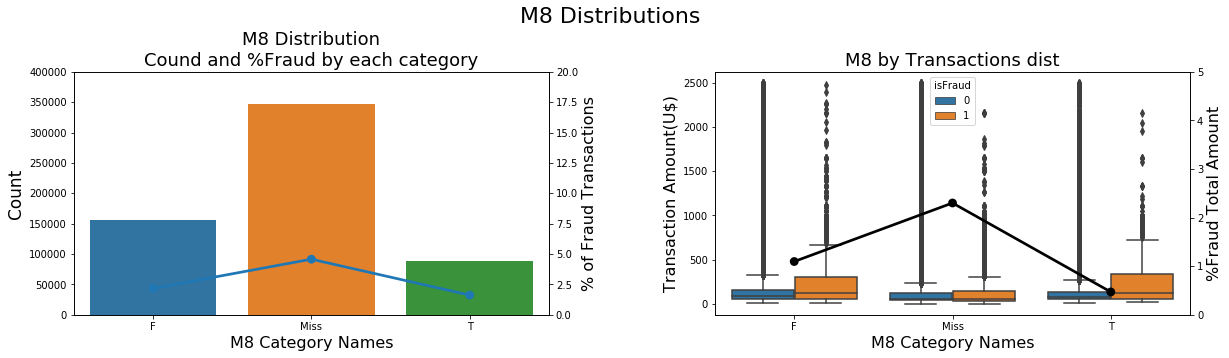

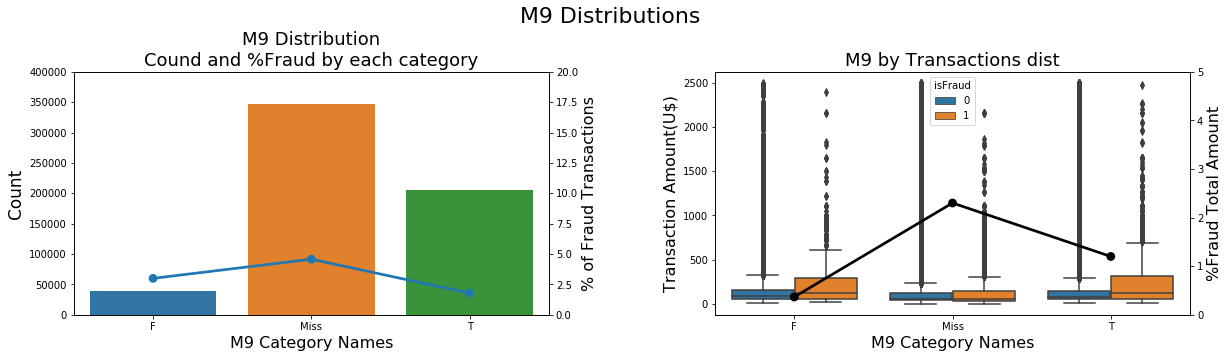

In [12]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    try:
        tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

        plt.figure(figsize=(20,5))
        plt.suptitle(f'{col} Distributions ', fontsize=22)

        plt.subplot(121)
        g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
        # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
        g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
        g.set_ylim(0,400000)
        gt = g.twinx()
        gt = sns.pointplot(x=col, y='Fraud', data=tmp)
        gt.set_ylim(0,20)
        gt.set_ylabel("% of Fraud Transactions", fontsize=16)
        g.set_xlabel(f"{col} Category Names", fontsize=16)
        g.set_ylabel("Count", fontsize=17)
        for p in gt.patches:
            height = p.get_height()
            gt.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center",fontsize=14) 

        perc_amt = (train.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
        perc_amt = perc_amt.reset_index()
        perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

        plt.subplot(122)
        g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                         data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
        g1t = g1.twinx()
        g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                           color='black', legend=False, )
        g1t.set_ylim(0,5)
        g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
        g1.set_title(f"{col} by Transactions dist", fontsize=18)
        g1.set_xlabel(f"{col} Category Names", fontsize=16)
        g1.set_ylabel("Transaction Amount(U$)", fontsize=16)

        plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)

        plt.show()
    except:
        return 'fail'
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train, col, lim=2500)

Some more visualizations, nothing is a huge standout here though. At least in terms of the target feature

In [13]:
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [14]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    


Let's look and see how the addresses can have an impact on this as well

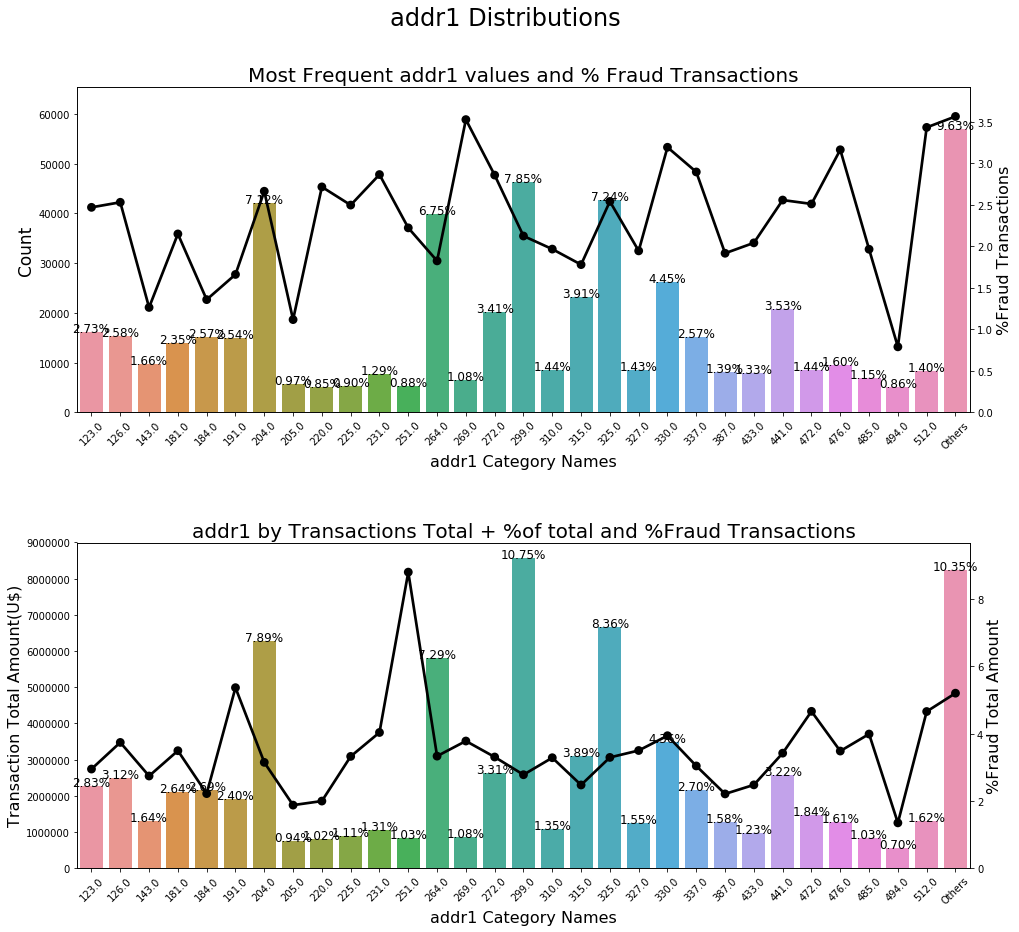

In [15]:
ploting_cnt_amt(train, 'addr1')

There doesn't appear to be a linear relationship, but the model might still be able to pick something up from this variance. 

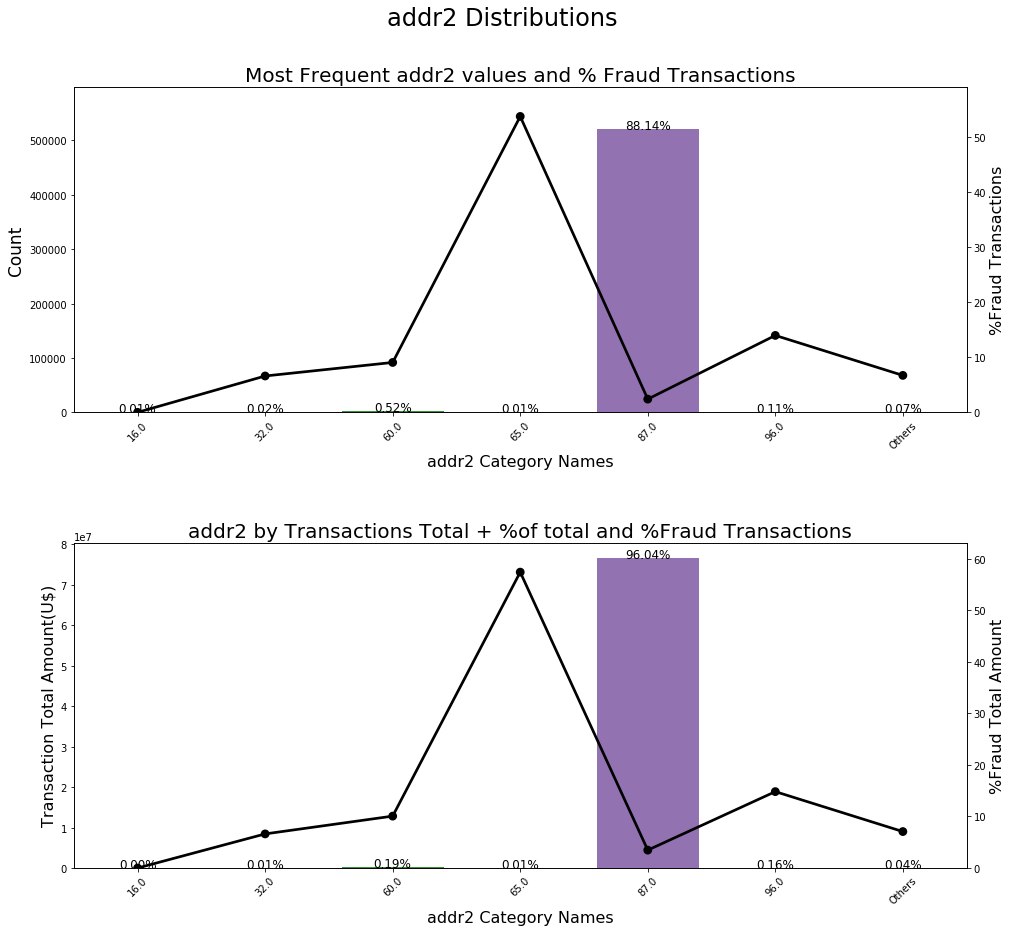

In [16]:
ploting_cnt_amt(train, 'addr2')


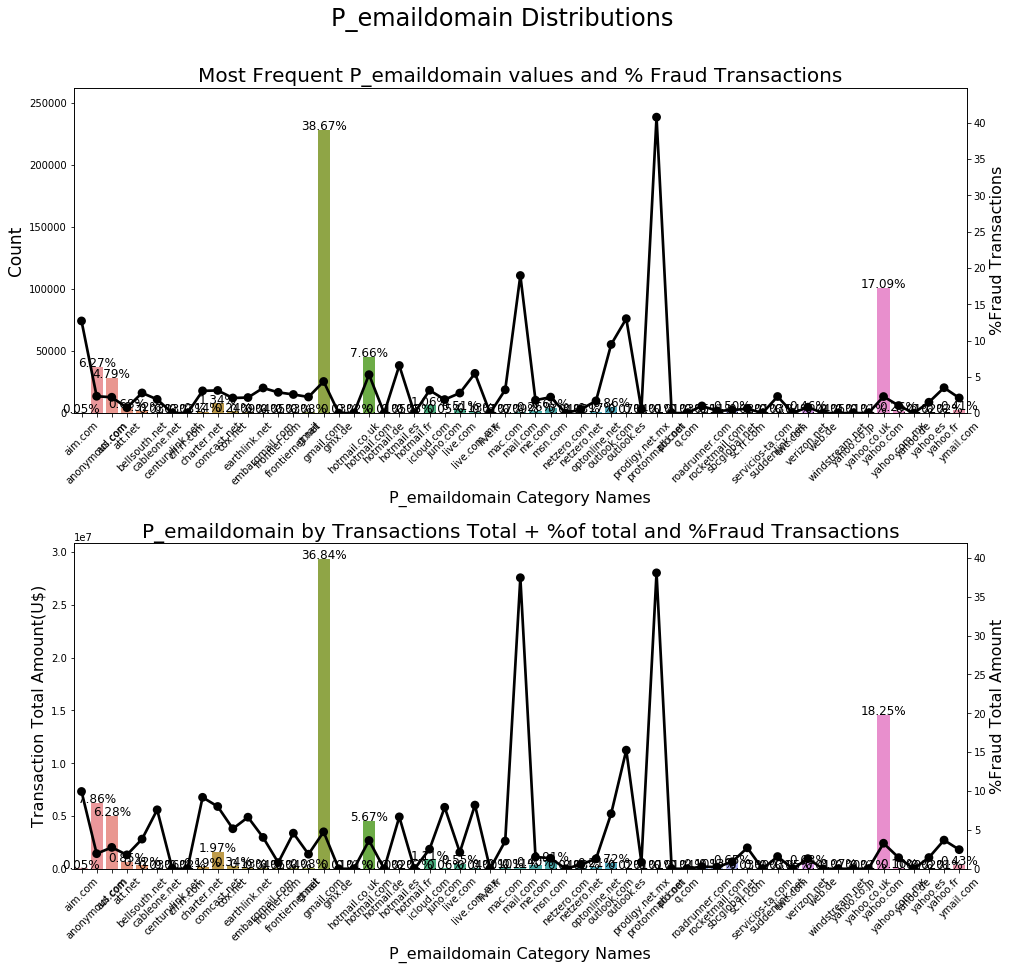

In [17]:
ploting_cnt_amt(train, 'P_emaildomain')


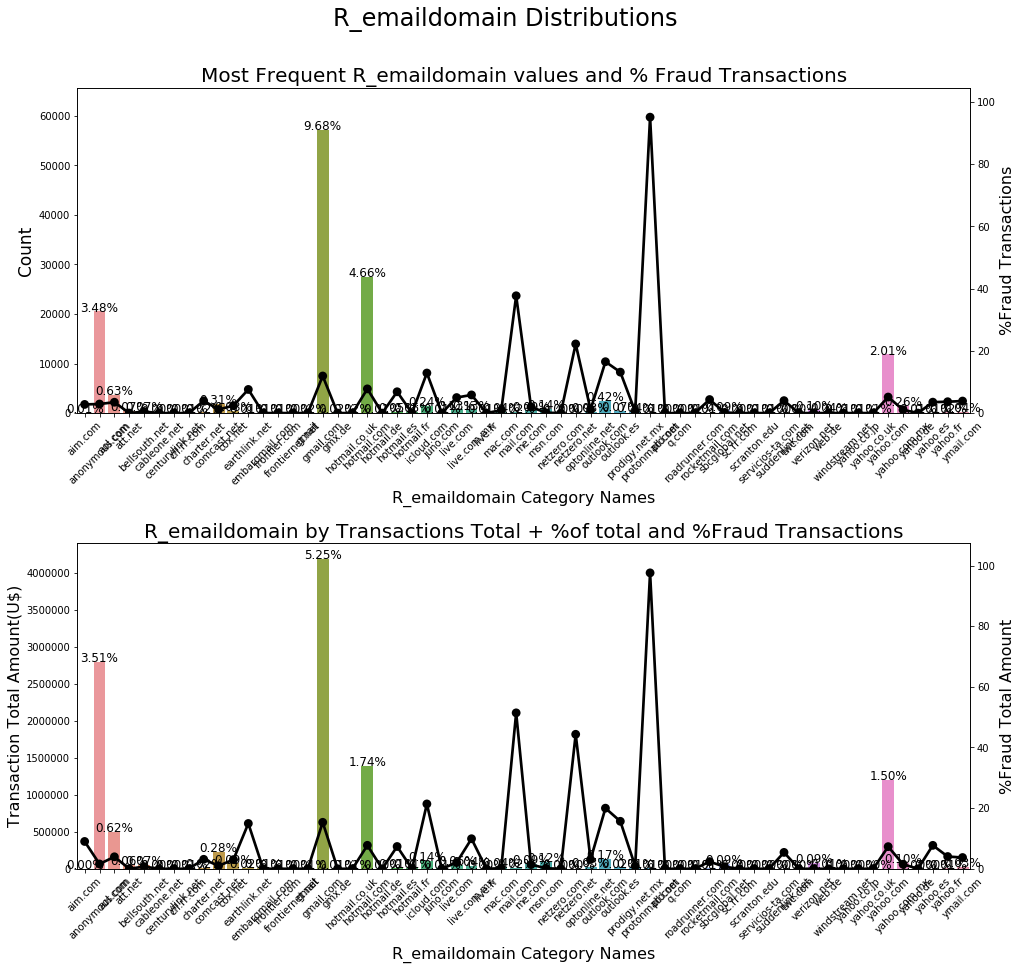

In [18]:
ploting_cnt_amt(train, 'R_emaildomain')


Emails seems to have some utility. Prodigy.net.mix seems to be almost entirely composed of fraudulent transactions. 

In [19]:
train.loc[train.C1.isin(train.C1\
                              .value_counts()[train.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

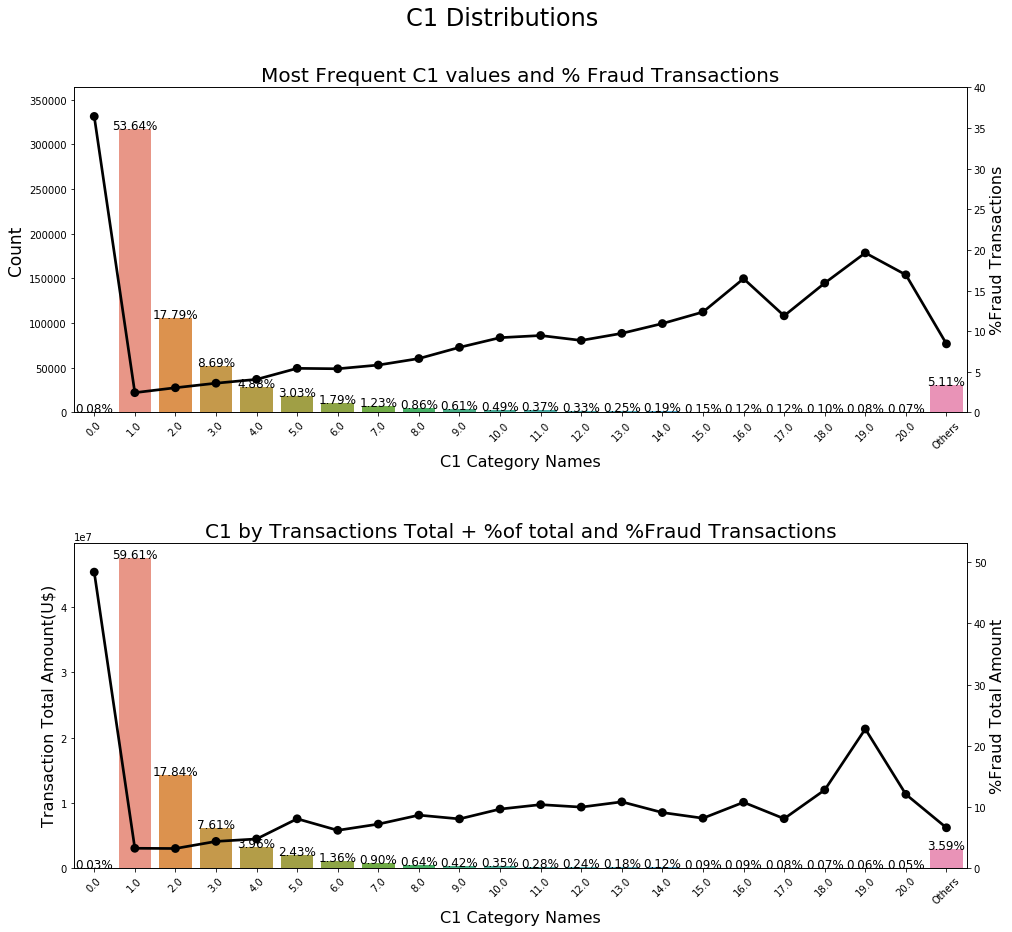

In [20]:
ploting_cnt_amt(train, 'C1')


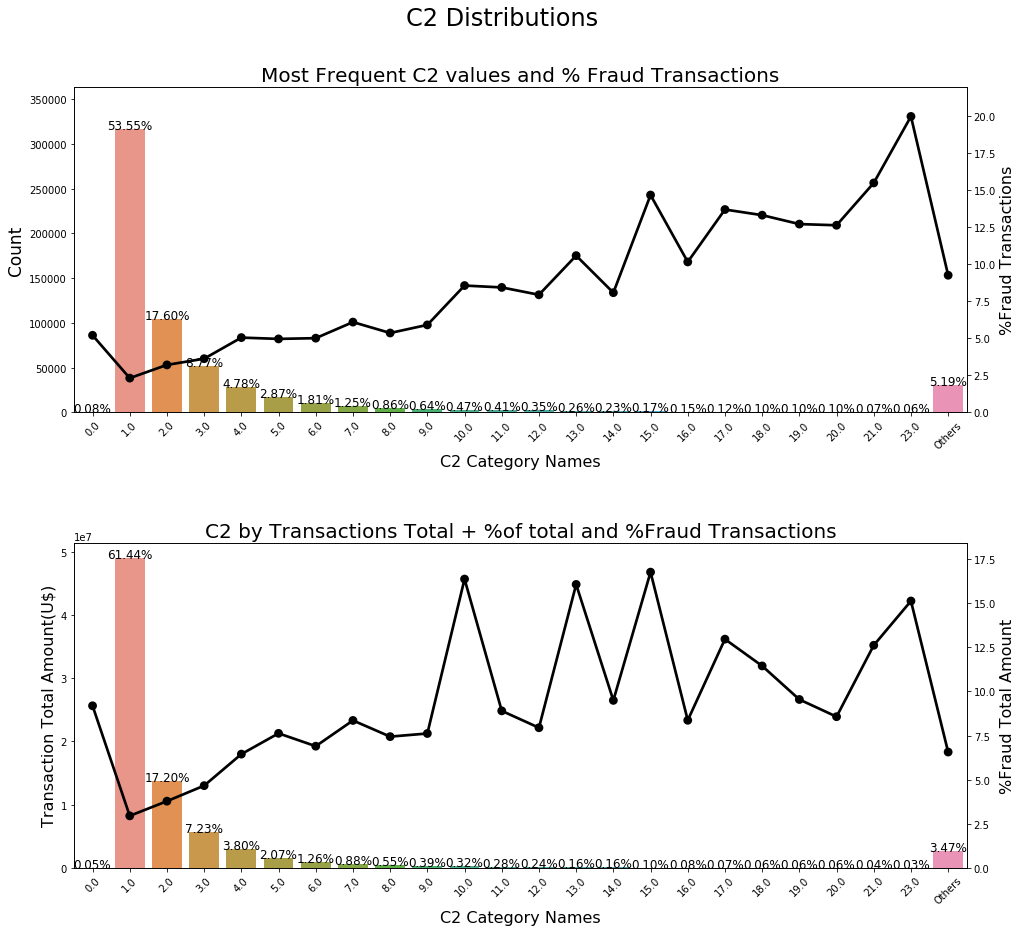

In [21]:
train.loc[train.C2.isin(train.C2
                              .value_counts()[train.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"
ploting_cnt_amt(train, 'C2')


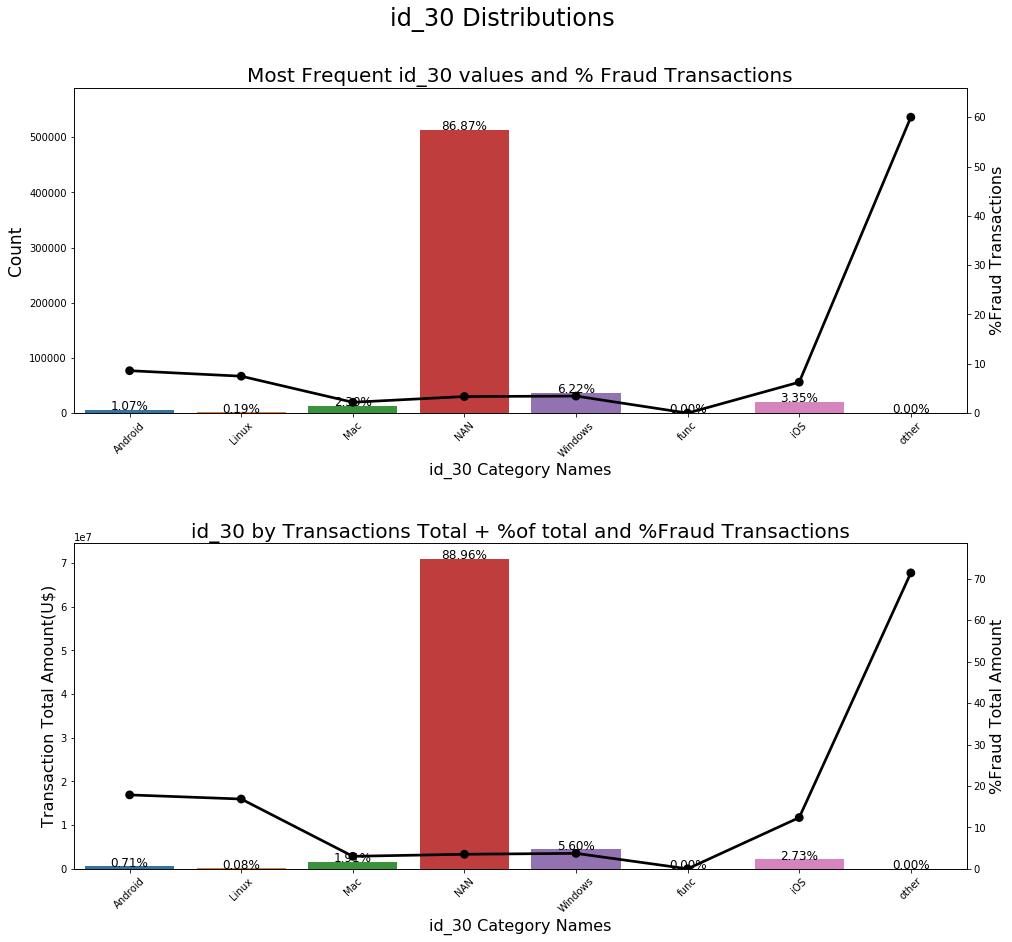

In [22]:
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

ploting_cnt_amt(train, 'id_30')


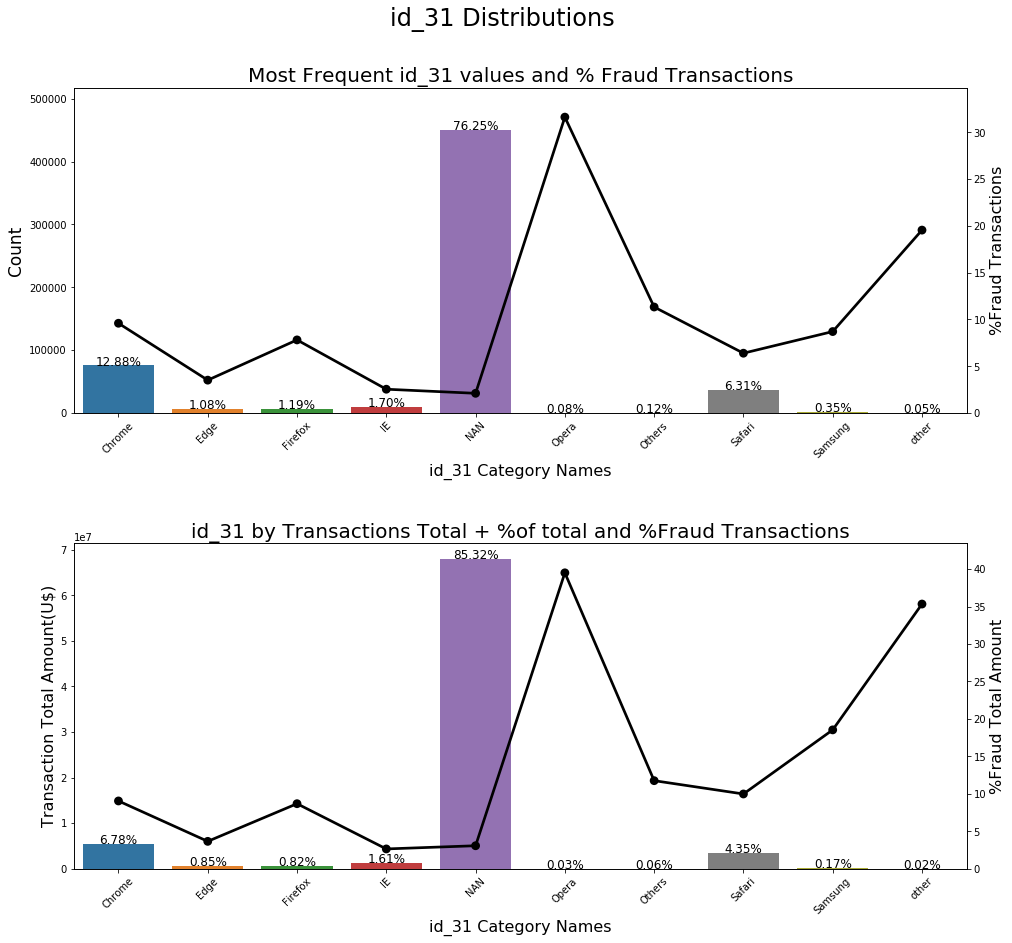

In [23]:
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

ploting_cnt_amt(train, 'id_31')


A few features we found significant from previous notebooks

In [24]:
is_apple = []
for i in train.id_31:
    if 'ios' in str(i):
        is_apple.append(1)
    elif 'safari' in str(i):
        is_apple.append(1)
    else:
        is_apple.append(0)
is_apple_series = pd.Series(is_apple)


In [25]:
target = "isFraud"
_id = "TransactionID"

def data_prep(data, isTest=0):
    keep_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
#     keep_cols = ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 
#                  'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']
    
    if isTest:
        pass
    else:
        keep_cols += [target]
        
    used_cols = [col for col in keep_cols if col not in [target]]

    return data[keep_cols].copy(), keep_cols, used_cols

train, keep_cols, used_cols = data_prep(train)
gc.collect()

12025

In [30]:
columns_a = ['TransactionAmt', 'id_02', 'D15']
columns_b = ['card1', 'card4', 'addr1']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [train, test]:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

In [31]:
from sklearn.preprocessing import LabelEncoder

train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [32]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

# Reducing Memory Usage

In [33]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2164.87 MB
Memory usage after optimization is: 595.97 MB
Decreased by 72.5%
Memory usage of dataframe is 1857.49 MB
Memory usage after optimization is: 532.63 MB
Decreased by 71.3%


# A few more new features, averages, standard deviations

In [34]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

# Apple phones have been found to rarely been used to commit the fraud, so we're making all IOS phones a separate feature

In [35]:
is_apple = []
for i in train.id_31:
    if 'ios' in str(i):
        is_apple.append(500)
    elif 'safari' in str(i):
        is_apple.append(500)
    elif 'NaN' in str(i):
        is_apple.append(0)
    else:
        is_apple.append(-500)

is_apple_test = []
for i in test.id_31:
    if 'ios' in str(i):
        is_apple_test.append(500)
    elif 'safari' in str(i):
        is_apple_test.append(500)
    elif 'NaN' in str(i):
        is_apple_test.append(0)
    else:
        is_apple_test.append(-500)
        


train['is_apple']=is_apple
test['is_apple']=is_apple_test


In [36]:
train.C1 = train.C1.replace('Others', 999)
train.C2 = train.C2.replace('Others', 999)
test.C1 = test.C1.replace('Others', 999)
test.C2 = test.C2.replace('Others', 999)

In [37]:
Sum_C_Train = sum([train.C1, train.C2,train.C4,train.C5,train.C6,train.C7,train.C8,train.C9,train.C10,train.C11,train.C12, train.C13, train.C14])  
Sum_C_Test = sum([test.C1,test.C2,test.C4,test.C5,test.C6,test.C7,test.C8,test.C9,test.C10,test.C11,test.C12, test.C13, test.C14])

In [38]:
Sum_D_Train = sum([train.D1,train.D2,train.D3,train.D4,train.D5,train.D6,train.D8,train.D9,train.D10,train.D11,train.D12,train.D13,train.D14,train.D15])
Sum_D_Test = sum([test.D1, test.D2, test.D3, test.D4, test.D5, test.D6, test.D8, test.D9, test.D10, test.D11, test.D12, test.D13, test.D14, test.D15])

In [39]:
List_of_Ms=['M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
tired = []
for i in List_of_Ms:
    poggies = []
    for j in train[i]:
        if j == 'T':
            poggies.append(1)
        else:
            poggies.append(0)
    tired.append(poggies)
    
from numpy import array
tired = array(tired)
tired_train = sum(tired,0)

tired_test = []
for i in List_of_Ms:
    poggies_test = []
    for j in test[i]:
        if j == 'T':
            poggies_test.append(1)
        else:
            poggies_test.append(0)
    tired_test.append(poggies_test)
    
from numpy import array
tired_test = array(tired_test)
tired_test = sum(tired_test,0)

### gmail and mail have are often used for fraudulent transactions at a disproportionately high percentage

In [40]:
p_mail_list = []
for i in train.P_emaildomain:
    if str(i) == 'mail.com':
        p_mail_list.append(1)
    else:
        p_mail_list.append(0)

r_mail_list = []
for i in train.R_emaildomain:
    if str(i) == 'gmail.com':
        r_mail_list.append(1)
    elif str(i) == 'icloud.com':
        r_mail_list.append(1)
    else:
        r_mail_list.append(0)

p_mail_list_test = []
for i in test.P_emaildomain:
    if str(i) == 'mail.com':
        p_mail_list_test.append(1)
    else:
        p_mail_list_test.append(0)

r_mail_list_test = []
for i in test.R_emaildomain:
    if str(i) == 'gmail.com':
        r_mail_list_test.append(1)
    elif str(i) == 'icloud.com':
        r_mail_list_test.append(1)
    else:
        r_mail_list_test.append(0)


In [41]:
cum_mail_list=[sum(x) for x in zip(p_mail_list, r_mail_list)]
len(cum_mail_list)
cum_mail_list_test=[sum(x) for x in zip(p_mail_list_test, r_mail_list_test)]
len(cum_mail_list_test)
# for i in range(len(cum_mail_list)):
#     if cum_mail_list[i] == 0:
#         cum_mail_list[i] = 'zero'
#     if cum_mail_list[i] == 1:
#         cum_mail_list[i] = 'one'
#     if cum_mail_list[i] == 2:
#         cum_mail_list[i] = 'two'
        
# for i in range(len(cum_mail_list_test)):
#     if cum_mail_list_test[i] == 0:
#         cum_mail_list_test[i] = 'zero'
#     if cum_mail_list_test[i] == 1:
#         cum_mail_list_test[i] = 'one'
#     if cum_mail_list_test[i] == 2:
#         cum_mail_list_test[i] = 'two'

506691

In [42]:
train.addr1 = train.addr1.replace('Others', 999)
train.addr2 = train.addr2.replace('Others', 999)
test.addr1 = test.addr1.replace('Others', 999)
test.addr2 = test.addr2.replace('Others', 999)

In [43]:
train.addr1.unique()

array([315., 325., 330., 476., 999., 272., 126., 337., 204.,  nan, 184.,
       264., 299., 441., 472., 251., 191., 485., 220., 205., 387., 181.,
       231., 327., 123., 269., 433., 143., 225., 512., 310., 494.])

In [44]:
train.addr1=train.addr1.fillna(0)
train.addr2=train.addr2.fillna(0)
test.addr1 = test.addr1.fillna(0)
test.addr2 = test.addr2.fillna(0)
train.dist1 = train.dist1.fillna(0)

test.dist1 = train.dist1.fillna(0)
mean_address_train= (train.addr1+train.addr2)/2
mean_address_test = (test.addr1+test.addr2)/2
train['is_apple']=is_apple
test['is_apple']=is_apple_test
train['sus_email']=cum_mail_list
test['sus_email']=cum_mail_list_test
train['sum_C']=Sum_C_Train
test['sum_C']=Sum_C_Test
train['sum_D']=Sum_D_Train
test['sum_D']=Sum_D_Test
train['sum_M']=tired_train
test['sum_M']=tired_test
train['mean_addr']=mean_address_train
test['mean_addr']=mean_address_test
used_cols.append('is_apple')
used_cols.append('sus_email')
used_cols.append('sum_C')
used_cols.append('sum_D')
used_cols.append('sum_M')
used_cols.append('mean_addr')
#used_cols.append('mean_dist')

In [46]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.drop(['TransactionDT'], axis=1)

# del train, test
gc.collect()

167

In [49]:
sparse_cols = []
for i in X.columns.tolist():
    spars= X[i].dtype
    if 'Sparse' in str(spars):
        sparse_cols.append(spars)
        X[i]=X[i].astype('category')
        X[i]=X[i].astype('float')
        


# sparse_cols = []
# for i in X_test.columns.tolist():
#     spars= X_test[i].dtype
#     if 'Sparse' in str(spars):
#         sparse_cols.append(spars)
#         X_test[i]=X_test[i].astype('category')
#         X_test[i]=X_test[i].astype('float')

### gridsearched to find best parameters previously 

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

# LGBM MODEL

In [54]:
%%time

NFOLDS = 2
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    X_test = X_valid
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
# print(f"\nMean AUC = {score}")
# print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.970041	valid_1's auc: 0.891692
[400]	training's auc: 0.988425	valid_1's auc: 0.900108
[600]	training's auc: 0.996275	valid_1's auc: 0.903699
[800]	training's auc: 0.998931	valid_1's auc: 0.905107
[1000]	training's auc: 0.999717	valid_1's auc: 0.905712
Early stopping, best iteration is:
[973]	training's auc: 0.999662	valid_1's auc: 0.905751
Fold 1 | AUC: 0.9057509846155524
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972535	valid_1's auc: 0.894447
[400]	training's auc: 0.989658	valid_1's auc: 0.903235
[600]	training's auc: 0.996981	valid_1's auc: 0.908222
[800]	training's auc: 0.999242	valid_1's auc: 0.908981
Early stopping, best iteration is:
[768]	training's auc: 0.999038	valid_1's auc: 0.909012
Fold 2 | AUC: 0.9090119810639098
Wall time: 7min 40s


In [55]:
# predict
y_pred = clf.predict(X_test)

In [56]:
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")



Mean AUC = 0.9073814828397311
Out of folds AUC = 0.9070933186887163
